In [2]:
from utils import (ConstructDataset, Generator, Discriminator)
import random
from torchvision import transforms
import torchvision.transforms as transforms
import torch
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

<strong> Building the dataset </strong>

In [3]:
# Building the dataset

image_dir = '../../data/pixel_art/images/images/'

transform = transforms.Compose([
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])



images = ConstructDataset(image_dir, transform)

<strong> Sampling an image from the dataset </strong>

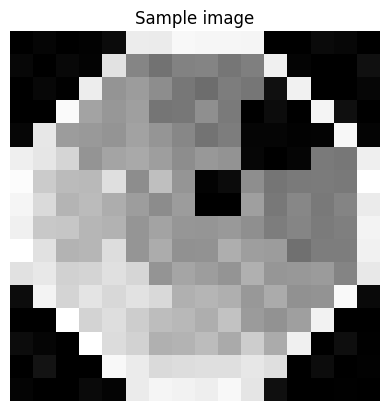

In [4]:
# Plotting an example from  the dataset
n = len(images)
integer = random.randint(0,n)
image = images[integer].numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample image')
plt.show()


<strong> Building the dataloader </strong>

In [5]:
dataloader = DataLoader(images, batch_size=256)

<strong> Building the models </strong>

In [6]:
# Model's parameters
latent_dim = 40
channels_out = 3
channels_in = 3

# Intializing the models
G = Generator(latent_dim, channels_out)
D = Discriminator(channels_in)

In [7]:
images[0].unsqueeze(0).size()

torch.Size([1, 3, 16, 16])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 16, 16])


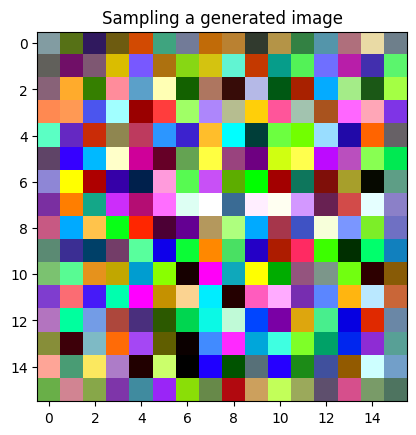

In [8]:
sample_image = images[0].unsqueeze(0)
noise_image = D(sample_image)

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)
print(fake_images.size())

# Plotting the image 
image_noise = fake_images.detach().numpy().reshape((3,16,16))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Training loop </strong>

In [8]:
# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define models and parameters 
generator = G.to(device)  # Move generator to GPU
discriminator = D.to(device)  # Move discriminator to GPU
epochs = 300
epoch_eval = epochs // 10
k = 3 # Steps to train generator
epoch_print = 1 # Print performance
latent_dim = 40

# Loss function and optimizers
criterion = torch.nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.99, 0.99))
optimizer_d = optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.99, 0.99))


fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(images)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([images[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []
D_loss = []
G_loss =  []


for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):

        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_real = torch.ones(batch_size, 1, device=device)  # Real labels on GPU

        # Train discriminator with real images
        discriminator.zero_grad()
        output = discriminator(real_images)
        loss_d_real = criterion(output, labels_real)

        # Train discriminator with fake images
        labels_fake = torch.zeros(batch_size, 1, device=device)  # Real labels on GPU
        noise = torch.rand(batch_size, latent_dim, 1, 1, device=device) * 2 - 1

         # Generate noise on GPU
        fake_images = generator(noise)

        output = discriminator(fake_images.detach())
        loss_d_fake = criterion(output, labels_fake)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d.step()

        if epoch % k == 0:
            # Train generator
            labels_real_g = torch.ones(batch_size, 1, device=device)  # Real labels on GPU

            generator.zero_grad()

            output = discriminator(fake_images)
            loss_g = criterion(output, labels_real_g)
            loss_g.backward()

            optimizer_g.step()
    
    if epoch % epoch_eval == 0:
        # Eval mode
        G_eval = generator.eval()

        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_eval(noise).to(torch.device('cpu'))

        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)

        # Storing loss values
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())

        # Train mode
        generator.train()
    
    end_time = time.time()
    if epoch % epoch_print == 0:

        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [0/300] | Loss D: 0.693151593208313 | Loss G: 3.1443121433258057
Epoch 1 duration :   30.13755750656128


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/300] | Loss D: 0.019378662109375 | Loss G: 3.1443121433258057
Epoch 2 duration :   4.582530498504639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/300] | Loss D: 0.0005677276640199125 | Loss G: 3.1443121433258057
Epoch 3 duration :   4.2151594161987305


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/300] | Loss D: 5.568828105926514 | Loss G: 1.954835295677185
Epoch 4 duration :   8.636917352676392


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/300] | Loss D: 0.0029002781957387924 | Loss G: 1.954835295677185
Epoch 5 duration :   4.3490612506866455


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/300] | Loss D: 0.006113794632256031 | Loss G: 1.954835295677185
Epoch 6 duration :   4.471611976623535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/300] | Loss D: 0.22285054624080658 | Loss G: 18.737768173217773
Epoch 7 duration :   9.08980417251587


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/300] | Loss D: 0.28002357482910156 | Loss G: 18.737768173217773
Epoch 8 duration :   4.32829213142395


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/300] | Loss D: 0.08528678864240646 | Loss G: 18.737768173217773
Epoch 9 duration :   4.22412109375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/300] | Loss D: 0.03584330901503563 | Loss G: 18.336320877075195
Epoch 10 duration :   9.325165271759033


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/300] | Loss D: 0.025922980159521103 | Loss G: 18.336320877075195
Epoch 11 duration :   4.47017765045166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/300] | Loss D: 0.02334991842508316 | Loss G: 18.336320877075195
Epoch 12 duration :   4.528491735458374


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/300] | Loss D: 0.021425845101475716 | Loss G: 10.837652206420898
Epoch 13 duration :   9.03580617904663


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/300] | Loss D: 0.023373963311314583 | Loss G: 10.837652206420898
Epoch 14 duration :   4.451963424682617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/300] | Loss D: 0.016114676371216774 | Loss G: 10.837652206420898
Epoch 15 duration :   4.321991443634033


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/300] | Loss D: 1.0633556842803955 | Loss G: 2.0486607551574707
Epoch 16 duration :   9.171838283538818


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/300] | Loss D: 0.03951340168714523 | Loss G: 2.0486607551574707
Epoch 17 duration :   4.346505641937256


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/300] | Loss D: 0.03180487081408501 | Loss G: 2.0486607551574707
Epoch 18 duration :   4.277774333953857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/300] | Loss D: 0.04510254040360451 | Loss G: 13.902244567871094
Epoch 19 duration :   9.187013626098633


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/300] | Loss D: 0.0533597394824028 | Loss G: 13.902244567871094
Epoch 20 duration :   4.40400242805481


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/300] | Loss D: 0.06020057946443558 | Loss G: 13.902244567871094
Epoch 21 duration :   4.1974711418151855


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/300] | Loss D: 0.050565991550683975 | Loss G: 16.450708389282227
Epoch 22 duration :   8.962284803390503


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/300] | Loss D: 0.04005765914916992 | Loss G: 16.450708389282227
Epoch 23 duration :   4.419599294662476


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/300] | Loss D: 0.03075156733393669 | Loss G: 16.450708389282227
Epoch 24 duration :   4.6801817417144775


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/300] | Loss D: 0.02168898656964302 | Loss G: 17.049184799194336
Epoch 25 duration :   8.89117956161499


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/300] | Loss D: 0.015580832958221436 | Loss G: 17.049184799194336
Epoch 26 duration :   4.294351816177368


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/300] | Loss D: 0.01045450009405613 | Loss G: 17.049184799194336
Epoch 27 duration :   4.322747707366943


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/300] | Loss D: 0.0077361795119941235 | Loss G: 16.163742065429688
Epoch 28 duration :   9.625407218933105


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/300] | Loss D: 0.005890997126698494 | Loss G: 16.163742065429688
Epoch 29 duration :   4.462979078292847


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/300] | Loss D: 0.004747967701405287 | Loss G: 16.163742065429688
Epoch 30 duration :   4.454142808914185


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/300] | Loss D: 0.003199750790372491 | Loss G: 13.54712963104248
Epoch 31 duration :   27.926586866378784


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/300] | Loss D: 0.0027969975490123034 | Loss G: 13.54712963104248
Epoch 32 duration :   4.235938310623169


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/300] | Loss D: 0.0019250961486250162 | Loss G: 13.54712963104248
Epoch 33 duration :   3.5759124755859375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/300] | Loss D: 0.007911685854196548 | Loss G: 7.976467609405518
Epoch 34 duration :   7.758288621902466


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/300] | Loss D: 0.013793352991342545 | Loss G: 7.976467609405518
Epoch 35 duration :   4.034325122833252


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/300] | Loss D: 0.002274520229548216 | Loss G: 7.976467609405518
Epoch 36 duration :   3.9193458557128906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/300] | Loss D: 0.1013418436050415 | Loss G: 4.11627197265625
Epoch 37 duration :   9.103994846343994


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/300] | Loss D: 0.019898904487490654 | Loss G: 4.11627197265625
Epoch 38 duration :   4.2631847858428955


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/300] | Loss D: 0.0010937098413705826 | Loss G: 4.11627197265625
Epoch 39 duration :   3.6997227668762207


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/300] | Loss D: 0.0017677036812528968 | Loss G: 9.520066261291504
Epoch 40 duration :   7.291715621948242


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/300] | Loss D: 0.0010396180441603065 | Loss G: 9.520066261291504
Epoch 41 duration :   3.84321928024292


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/300] | Loss D: 0.0009242010419256985 | Loss G: 9.520066261291504
Epoch 42 duration :   4.010882377624512


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/300] | Loss D: 0.0014271480031311512 | Loss G: 14.036704063415527
Epoch 43 duration :   8.527016878128052


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/300] | Loss D: 0.0007869252585805953 | Loss G: 14.036704063415527
Epoch 44 duration :   3.979854106903076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/300] | Loss D: 0.0014228650834411383 | Loss G: 14.036704063415527
Epoch 45 duration :   4.025733709335327


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/300] | Loss D: 0.0012680651852861047 | Loss G: 17.52979278564453
Epoch 46 duration :   8.306614875793457


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/300] | Loss D: 0.002330707386136055 | Loss G: 17.52979278564453
Epoch 47 duration :   4.113759517669678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/300] | Loss D: 0.0012436073739081621 | Loss G: 17.52979278564453
Epoch 48 duration :   3.9109344482421875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/300] | Loss D: 0.0014426959678530693 | Loss G: 20.581233978271484
Epoch 49 duration :   8.476947546005249


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/300] | Loss D: 0.0012473978567868471 | Loss G: 20.581233978271484
Epoch 50 duration :   3.9108049869537354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/300] | Loss D: 0.0014599811984226108 | Loss G: 20.581233978271484
Epoch 51 duration :   3.875711679458618


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [51/300] | Loss D: 0.0014190839137881994 | Loss G: 23.263874053955078
Epoch 52 duration :   8.158536195755005


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [52/300] | Loss D: 0.0012626460520550609 | Loss G: 23.263874053955078
Epoch 53 duration :   3.5498738288879395


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [53/300] | Loss D: 0.0025518150068819523 | Loss G: 23.263874053955078
Epoch 54 duration :   3.614091634750366


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [54/300] | Loss D: 0.001502401428297162 | Loss G: 25.588211059570312
Epoch 55 duration :   7.402836084365845


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [55/300] | Loss D: 0.0009006195468828082 | Loss G: 25.588211059570312
Epoch 56 duration :   3.4996652603149414


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [56/300] | Loss D: 0.001533056260086596 | Loss G: 25.588211059570312
Epoch 57 duration :   3.6648223400115967


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [57/300] | Loss D: 0.001467888243496418 | Loss G: 27.903446197509766
Epoch 58 duration :   8.354130506515503


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [58/300] | Loss D: 0.0006259735091589391 | Loss G: 27.903446197509766
Epoch 59 duration :   3.905247211456299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [59/300] | Loss D: 0.0004646821762435138 | Loss G: 27.903446197509766
Epoch 60 duration :   3.9557595252990723


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [60/300] | Loss D: 0.0007660351111553609 | Loss G: 29.90386390686035
Epoch 61 duration :   29.672475337982178


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [61/300] | Loss D: 0.0008271925617009401 | Loss G: 29.90386390686035
Epoch 62 duration :   4.7572245597839355


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [62/300] | Loss D: 0.0005110381753183901 | Loss G: 29.90386390686035
Epoch 63 duration :   4.0676209926605225


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [63/300] | Loss D: 0.0006645292160101235 | Loss G: 31.659038543701172
Epoch 64 duration :   8.435778141021729


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [64/300] | Loss D: 0.00031503327772952616 | Loss G: 31.659038543701172
Epoch 65 duration :   4.035152912139893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [65/300] | Loss D: 0.00024287134874612093 | Loss G: 31.659038543701172
Epoch 66 duration :   4.053945302963257


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [66/300] | Loss D: 0.0001652894716244191 | Loss G: 33.427452087402344
Epoch 67 duration :   8.467435836791992


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [67/300] | Loss D: 0.0001045040917233564 | Loss G: 33.427452087402344
Epoch 68 duration :   3.7996625900268555


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [68/300] | Loss D: 0.00016705122834537178 | Loss G: 33.427452087402344
Epoch 69 duration :   3.6106679439544678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [69/300] | Loss D: 0.00011075192014686763 | Loss G: 35.240257263183594
Epoch 70 duration :   7.09584379196167


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [70/300] | Loss D: 0.00010592881153570488 | Loss G: 35.240257263183594
Epoch 71 duration :   3.3925113677978516


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [71/300] | Loss D: 0.00014575633394997567 | Loss G: 35.240257263183594
Epoch 72 duration :   3.4384264945983887


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [72/300] | Loss D: 5.3123603720450774e-05 | Loss G: 36.65986251831055
Epoch 73 duration :   6.995657682418823


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [73/300] | Loss D: 4.7426059609279037e-05 | Loss G: 36.65986251831055
Epoch 74 duration :   3.4543979167938232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [74/300] | Loss D: 2.409436274319887e-05 | Loss G: 36.65986251831055
Epoch 75 duration :   3.4947662353515625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [75/300] | Loss D: 1.7606942492420785e-05 | Loss G: 37.60356521606445
Epoch 76 duration :   7.085390090942383


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [76/300] | Loss D: 2.502546522009652e-05 | Loss G: 37.60356521606445
Epoch 77 duration :   3.4332098960876465


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [77/300] | Loss D: 2.1727391867898405e-05 | Loss G: 37.60356521606445
Epoch 78 duration :   3.397221565246582


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [78/300] | Loss D: 2.4417646272922866e-05 | Loss G: 39.47090530395508
Epoch 79 duration :   7.053283214569092


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [79/300] | Loss D: 6.82982226862805e-06 | Loss G: 39.47090530395508
Epoch 80 duration :   3.3473525047302246


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [80/300] | Loss D: 8.86731686478015e-06 | Loss G: 39.47090530395508
Epoch 81 duration :   3.4265177249908447


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [81/300] | Loss D: 2.1673462470062077e-05 | Loss G: 40.74214553833008
Epoch 82 duration :   7.092765808105469


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [82/300] | Loss D: 6.755042250006227e-06 | Loss G: 40.74214553833008
Epoch 83 duration :   3.491929054260254


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [83/300] | Loss D: 6.530206974275643e-06 | Loss G: 40.74214553833008
Epoch 84 duration :   3.3843421936035156


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [84/300] | Loss D: 2.640143748067203e-06 | Loss G: 41.84999084472656
Epoch 85 duration :   7.180438995361328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [85/300] | Loss D: 1.0278302397637162e-05 | Loss G: 41.84999084472656
Epoch 86 duration :   3.376063108444214


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [86/300] | Loss D: 4.32792830906692e-06 | Loss G: 41.84999084472656
Epoch 87 duration :   3.455378770828247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [87/300] | Loss D: 2.0944337393302703e-06 | Loss G: 42.88375473022461
Epoch 88 duration :   7.034640550613403


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [88/300] | Loss D: 6.4793975980137475e-06 | Loss G: 42.88375473022461
Epoch 89 duration :   3.3756463527679443


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [89/300] | Loss D: 1.6288822735077702e-06 | Loss G: 42.88375473022461
Epoch 90 duration :   3.4540863037109375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [90/300] | Loss D: 2.3763700482959393e-06 | Loss G: 44.070655822753906
Epoch 91 duration :   21.29916214942932


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [91/300] | Loss D: 4.201393039693357e-06 | Loss G: 44.070655822753906
Epoch 92 duration :   4.008602619171143


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [92/300] | Loss D: 8.021008284231357e-07 | Loss G: 44.070655822753906
Epoch 93 duration :   3.396170139312744


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [93/300] | Loss D: 1.879452952380234e-06 | Loss G: 44.88539123535156
Epoch 94 duration :   6.994194030761719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [94/300] | Loss D: 2.218311919932603e-06 | Loss G: 44.88539123535156
Epoch 95 duration :   3.5153865814208984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [95/300] | Loss D: 2.6705504296842264e-06 | Loss G: 44.88539123535156
Epoch 96 duration :   3.4648773670196533


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [96/300] | Loss D: 4.6039770040806616e-07 | Loss G: 45.65591049194336
Epoch 97 duration :   7.005951642990112


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [97/300] | Loss D: 5.801218776468886e-07 | Loss G: 45.65591049194336
Epoch 98 duration :   3.506279468536377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [98/300] | Loss D: 1.4567502830686863e-06 | Loss G: 45.65591049194336
Epoch 99 duration :   3.5160295963287354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [99/300] | Loss D: 5.164043272998242e-07 | Loss G: 46.48615646362305
Epoch 100 duration :   7.897619009017944


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [100/300] | Loss D: 1.0446555052112672e-06 | Loss G: 46.48615646362305
Epoch 101 duration :   4.0519397258758545


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [101/300] | Loss D: 9.094988513425051e-07 | Loss G: 46.48615646362305
Epoch 102 duration :   3.950408458709717


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [102/300] | Loss D: 7.409576028294396e-07 | Loss G: 47.298927307128906
Epoch 103 duration :   8.189176321029663


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [103/300] | Loss D: 2.1375537073708983e-07 | Loss G: 47.298927307128906
Epoch 104 duration :   4.007955074310303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [104/300] | Loss D: 2.969971433230967e-07 | Loss G: 47.298927307128906
Epoch 105 duration :   3.937598943710327


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [105/300] | Loss D: 1.1155711945320945e-06 | Loss G: 48.263301849365234
Epoch 106 duration :   8.091248035430908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [106/300] | Loss D: 3.3347922112625383e-07 | Loss G: 48.263301849365234
Epoch 107 duration :   4.034866094589233


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [107/300] | Loss D: 5.991563511997811e-07 | Loss G: 48.263301849365234
Epoch 108 duration :   3.9943594932556152


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [108/300] | Loss D: 2.702777521790267e-07 | Loss G: 48.850860595703125
Epoch 109 duration :   8.272215366363525


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [109/300] | Loss D: 1.9320172839343286e-07 | Loss G: 48.850860595703125
Epoch 110 duration :   3.9970498085021973


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [110/300] | Loss D: 5.436425567495462e-07 | Loss G: 48.850860595703125
Epoch 111 duration :   3.970557451248169


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [111/300] | Loss D: 5.133273361934698e-07 | Loss G: 49.630897521972656
Epoch 112 duration :   8.17431378364563


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [112/300] | Loss D: 1.6237190436640958e-07 | Loss G: 49.630897521972656
Epoch 113 duration :   3.9419329166412354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [113/300] | Loss D: 2.600028494725848e-07 | Loss G: 49.630897521972656
Epoch 114 duration :   3.9591996669769287


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [114/300] | Loss D: 3.098467686868389e-07 | Loss G: 49.913673400878906
Epoch 115 duration :   8.094966411590576


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [115/300] | Loss D: 1.3719376568133157e-07 | Loss G: 49.913673400878906
Epoch 116 duration :   4.028669357299805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [116/300] | Loss D: 8.68378648988255e-08 | Loss G: 49.913673400878906
Epoch 117 duration :   4.006152868270874


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [117/300] | Loss D: 1.1355737683516054e-07 | Loss G: 50.738502502441406
Epoch 118 duration :   8.239262342453003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [118/300] | Loss D: 9.66007860370155e-08 | Loss G: 50.738502502441406
Epoch 119 duration :   3.9291017055511475


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [119/300] | Loss D: 9.968380254576914e-08 | Loss G: 50.738502502441406
Epoch 120 duration :   3.907284736633301


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [120/300] | Loss D: 6.320152579064597e-08 | Loss G: 51.262203216552734
Epoch 121 duration :   22.849496841430664


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [121/300] | Loss D: 9.505948384003204e-08 | Loss G: 51.262203216552734
Epoch 122 duration :   4.684406518936157


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [122/300] | Loss D: 2.4407194132436416e-07 | Loss G: 51.262203216552734
Epoch 123 duration :   3.951479196548462


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [123/300] | Loss D: 7.03953162428661e-08 | Loss G: 51.59565353393555
Epoch 124 duration :   8.186463356018066


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [124/300] | Loss D: 6.731221446898417e-08 | Loss G: 51.59565353393555
Epoch 125 duration :   3.9643561840057373


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [125/300] | Loss D: 2.5177831375344795e-08 | Loss G: 51.59565353393555
Epoch 126 duration :   3.953648805618286


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [126/300] | Loss D: 7.70750787637553e-08 | Loss G: 52.348419189453125
Epoch 127 duration :   8.097646951675415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [127/300] | Loss D: 4.675886700056253e-08 | Loss G: 52.348419189453125
Epoch 128 duration :   4.047948360443115


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [128/300] | Loss D: 2.0039497172774645e-08 | Loss G: 52.348419189453125
Epoch 129 duration :   3.9746057987213135


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [129/300] | Loss D: 1.9269079132300249e-07 | Loss G: 52.81663513183594
Epoch 130 duration :   8.25788426399231


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [130/300] | Loss D: 6.525690565695186e-08 | Loss G: 52.81663513183594
Epoch 131 duration :   4.020646810531616


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [131/300] | Loss D: 3.7509860106865744e-08 | Loss G: 52.81663513183594
Epoch 132 duration :   3.947129487991333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [132/300] | Loss D: 3.288533534373528e-08 | Loss G: 53.07439041137695
Epoch 133 duration :   8.398803472518921


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [133/300] | Loss D: 6.217391756990764e-08 | Loss G: 53.07439041137695
Epoch 134 duration :   4.030803203582764


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [134/300] | Loss D: 7.142296709616858e-08 | Loss G: 53.07439041137695
Epoch 135 duration :   3.9395086765289307


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [135/300] | Loss D: 3.905135415038785e-08 | Loss G: 53.240211486816406
Epoch 136 duration :   8.286075353622437


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [136/300] | Loss D: 1.4901168299275014e-08 | Loss G: 53.240211486816406
Epoch 137 duration :   3.8333823680877686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [137/300] | Loss D: 9.660137578748618e-08 | Loss G: 53.240211486816406
Epoch 138 duration :   3.624220848083496


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [138/300] | Loss D: 2.4664005948693557e-08 | Loss G: 53.78703308105469
Epoch 139 duration :   7.555697679519653


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [139/300] | Loss D: 7.81031772589813e-08 | Loss G: 53.78703308105469
Epoch 140 duration :   3.5387637615203857


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [140/300] | Loss D: 4.0079065399822866e-08 | Loss G: 53.78703308105469
Epoch 141 duration :   3.5176823139190674


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [141/300] | Loss D: 2.26086633858813e-08 | Loss G: 54.172149658203125
Epoch 142 duration :   7.32869815826416


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [142/300] | Loss D: 1.952566286433921e-08 | Loss G: 54.172149658203125
Epoch 143 duration :   3.554438352584839


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [143/300] | Loss D: 5.343880360442199e-08 | Loss G: 54.172149658203125
Epoch 144 duration :   3.563321352005005


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [144/300] | Loss D: 2.3636347989963724e-08 | Loss G: 54.43598556518555
Epoch 145 duration :   7.458269119262695


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [145/300] | Loss D: 1.644266411915396e-08 | Loss G: 54.43598556518555
Epoch 146 duration :   3.609048843383789


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [146/300] | Loss D: 3.0316193999624375e-08 | Loss G: 54.43598556518555
Epoch 147 duration :   3.513031482696533


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [147/300] | Loss D: 3.185768804314648e-08 | Loss G: 55.005069732666016
Epoch 148 duration :   7.482910394668579


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [148/300] | Loss D: 3.3913075014879723e-08 | Loss G: 55.005069732666016
Epoch 149 duration :   3.5154809951782227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [149/300] | Loss D: 1.027666485242662e-08 | Loss G: 55.005069732666016
Epoch 150 duration :   3.645252227783203


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [150/300] | Loss D: 3.545453353126504e-08 | Loss G: 55.244014739990234
Epoch 151 duration :   24.04840588569641


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [151/300] | Loss D: 2.8260854989525797e-08 | Loss G: 55.244014739990234
Epoch 152 duration :   4.962239742279053


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [152/300] | Loss D: 4.3675949967791894e-08 | Loss G: 55.244014739990234
Epoch 153 duration :   3.9285361766815186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [153/300] | Loss D: 1.027666574060504e-08 | Loss G: 55.232200622558594
Epoch 154 duration :   8.368264436721802


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [154/300] | Loss D: 3.1857680937719124e-08 | Loss G: 55.232200622558594
Epoch 155 duration :   4.0320985317230225


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [155/300] | Loss D: 7.19366521906295e-09 | Loss G: 55.232200622558594
Epoch 156 duration :   3.989231586456299


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [156/300] | Loss D: 1.130433169294065e-08 | Loss G: 55.5841178894043
Epoch 157 duration :   8.285181760787964


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [157/300] | Loss D: 2.0039504278202003e-08 | Loss G: 55.5841178894043
Epoch 158 duration :   3.9841148853302


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [158/300] | Loss D: 1.2845838170960633e-08 | Loss G: 55.5841178894043
Epoch 159 duration :   3.9919521808624268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [159/300] | Loss D: 3.494071521004116e-08 | Loss G: 55.92936706542969
Epoch 160 duration :   8.261556148529053


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [160/300] | Loss D: 2.569166213106655e-09 | Loss G: 55.92936706542969
Epoch 161 duration :   4.000602722167969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [161/300] | Loss D: 5.652165402381115e-09 | Loss G: 55.92936706542969
Epoch 162 duration :   3.990344762802124


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [162/300] | Loss D: 1.23319994216331e-08 | Loss G: 56.28577423095703
Epoch 163 duration :   8.188615322113037


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [163/300] | Loss D: 8.735164591655575e-09 | Loss G: 56.28577423095703
Epoch 164 duration :   4.111145734786987


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [164/300] | Loss D: 9.762834096704864e-09 | Loss G: 56.28577423095703
Epoch 165 duration :   4.00182580947876


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [165/300] | Loss D: 1.541500083135361e-08 | Loss G: 56.36058807373047
Epoch 166 duration :   8.247268199920654


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [166/300] | Loss D: 4.624499005956295e-09 | Loss G: 56.36058807373047
Epoch 167 duration :   4.00471305847168


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [167/300] | Loss D: 7.19366566315216e-09 | Loss G: 56.36058807373047
Epoch 168 duration :   3.960153818130493


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [168/300] | Loss D: 4.0079065399822866e-08 | Loss G: 56.72072982788086
Epoch 169 duration :   8.302916526794434


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [169/300] | Loss D: 3.18577519919927e-08 | Loss G: 56.72072982788086
Epoch 170 duration :   4.003286838531494


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [170/300] | Loss D: 4.11066602978849e-09 | Loss G: 56.72072982788086
Epoch 171 duration :   3.955791473388672


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [171/300] | Loss D: 4.624499005956295e-09 | Loss G: 56.47386169433594
Epoch 172 duration :   8.373409986495972


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [172/300] | Loss D: 1.0276671957853978e-08 | Loss G: 56.47386169433594
Epoch 173 duration :   4.041529893875122


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [173/300] | Loss D: 4.11066558569928e-09 | Loss G: 56.47386169433594
Epoch 174 duration :   3.9645841121673584


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [174/300] | Loss D: 1.1818173106803442e-08 | Loss G: 56.88542175292969
Epoch 175 duration :   8.234289169311523


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [175/300] | Loss D: 6.679831798805935e-09 | Loss G: 56.88542175292969
Epoch 176 duration :   3.980013370513916


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [176/300] | Loss D: 5.13833242621331e-09 | Loss G: 56.88542175292969
Epoch 177 duration :   3.907269239425659


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [177/300] | Loss D: 5.652165402381115e-09 | Loss G: 57.0154914855957
Epoch 178 duration :   8.216790437698364


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [178/300] | Loss D: 9.762832320348025e-09 | Loss G: 57.0154914855957
Epoch 179 duration :   4.015050888061523


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [179/300] | Loss D: 4.624499005956295e-09 | Loss G: 57.0154914855957
Epoch 180 duration :   3.958543539047241


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [180/300] | Loss D: 8.838000553623715e-08 | Loss G: 57.12899398803711
Epoch 181 duration :   22.362873792648315


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [181/300] | Loss D: 1.3873498794225725e-08 | Loss G: 57.12899398803711
Epoch 182 duration :   4.288933277130127


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [182/300] | Loss D: 1.1818166889554504e-08 | Loss G: 57.12899398803711
Epoch 183 duration :   3.907745361328125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [183/300] | Loss D: 4.11066558569928e-09 | Loss G: 57.034175872802734
Epoch 184 duration :   8.355727672576904


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [184/300] | Loss D: 2.56916599106205e-09 | Loss G: 57.034175872802734
Epoch 185 duration :   4.042395353317261


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [185/300] | Loss D: 5.1383319821241e-10 | Loss G: 57.034175872802734
Epoch 186 duration :   3.7251338958740234


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [186/300] | Loss D: 6.16599971081655e-09 | Loss G: 57.226165771484375
Epoch 187 duration :   7.53767466545105


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [187/300] | Loss D: 9.24899890009101e-09 | Loss G: 57.226165771484375
Epoch 188 duration :   3.670231580734253


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [188/300] | Loss D: 3.59683283157608e-09 | Loss G: 57.226165771484375
Epoch 189 duration :   3.7736783027648926


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [189/300] | Loss D: 3.596832609531475e-09 | Loss G: 57.44661331176758
Epoch 190 duration :   8.204948663711548


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [190/300] | Loss D: 1.02766639642482e-09 | Loss G: 57.44661331176758
Epoch 191 duration :   3.983328342437744


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [191/300] | Loss D: 6.679831798805935e-09 | Loss G: 57.44661331176758
Epoch 192 duration :   3.960566997528076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [192/300] | Loss D: 1.02766639642482e-09 | Loss G: 57.6600227355957
Epoch 193 duration :   8.14569902420044


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [193/300] | Loss D: 9.762832320348025e-09 | Loss G: 57.6600227355957
Epoch 194 duration :   3.9656965732574463


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [194/300] | Loss D: 3.59683283157608e-09 | Loss G: 57.6600227355957
Epoch 195 duration :   4.004366636276245


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [195/300] | Loss D: 5.1383319821241e-10 | Loss G: 57.62175369262695
Epoch 196 duration :   8.2042977809906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [196/300] | Loss D: 3.596832609531475e-09 | Loss G: 57.62175369262695
Epoch 197 duration :   4.088232040405273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [197/300] | Loss D: 6.6798340192519845e-09 | Loss G: 57.62175369262695
Epoch 198 duration :   4.022902965545654


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [198/300] | Loss D: 6.16600015490576e-09 | Loss G: 57.73350524902344
Epoch 199 duration :   8.32447338104248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [199/300] | Loss D: 3.082999411319065e-09 | Loss G: 57.73350524902344
Epoch 200 duration :   4.060833215713501


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [200/300] | Loss D: 5.1383319821241e-10 | Loss G: 57.73350524902344
Epoch 201 duration :   3.9952480792999268


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [201/300] | Loss D: 3.082999411319065e-09 | Loss G: 57.680030822753906
Epoch 202 duration :   8.280734062194824


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [202/300] | Loss D: 2.569166213106655e-09 | Loss G: 57.680030822753906
Epoch 203 duration :   4.028409242630005


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [203/300] | Loss D: 5.1383319821241e-10 | Loss G: 57.680030822753906
Epoch 204 duration :   3.9831249713897705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [204/300] | Loss D: 2.56916599106205e-09 | Loss G: 57.616790771484375
Epoch 205 duration :   8.275289297103882


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [205/300] | Loss D: 1.5414997056595325e-09 | Loss G: 57.616790771484375
Epoch 206 duration :   3.999116897583008


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [206/300] | Loss D: 6.16599882263813e-09 | Loss G: 57.616790771484375
Epoch 207 duration :   4.014776706695557


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [207/300] | Loss D: 3.082999411319065e-09 | Loss G: 58.13689041137695
Epoch 208 duration :   8.268779993057251


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [208/300] | Loss D: 2.05533279284964e-09 | Loss G: 58.13689041137695
Epoch 209 duration :   4.092724323272705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [209/300] | Loss D: 2.05533279284964e-09 | Loss G: 58.13689041137695
Epoch 210 duration :   4.024078607559204


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [210/300] | Loss D: 6.679834907430404e-09 | Loss G: 58.22787857055664
Epoch 211 duration :   21.809019088745117


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [211/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.22787857055664
Epoch 212 duration :   4.470388174057007


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [212/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.22787857055664
Epoch 213 duration :   3.915393590927124


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [213/300] | Loss D: 5.13833242621331e-09 | Loss G: 57.91394805908203
Epoch 214 duration :   8.174756288528442


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [214/300] | Loss D: 1.02766639642482e-09 | Loss G: 57.91394805908203
Epoch 215 duration :   3.925396203994751


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [215/300] | Loss D: 1.02766639642482e-09 | Loss G: 57.91394805908203
Epoch 216 duration :   3.894303560256958


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [216/300] | Loss D: 2.569166213106655e-09 | Loss G: 58.08513641357422
Epoch 217 duration :   8.242502212524414


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [217/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.08513641357422
Epoch 218 duration :   3.9739291667938232


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [218/300] | Loss D: 2.56916599106205e-09 | Loss G: 58.08513641357422
Epoch 219 duration :   3.938410520553589


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [219/300] | Loss D: 4.6600793617235166e-23 | Loss G: 58.103851318359375
Epoch 220 duration :   8.076000690460205


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [220/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.103851318359375
Epoch 221 duration :   3.9541890621185303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [221/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.103851318359375
Epoch 222 duration :   3.957550048828125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [222/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.145591735839844
Epoch 223 duration :   8.127973318099976


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [223/300] | Loss D: 1.1374735275953761e-23 | Loss G: 58.145591735839844
Epoch 224 duration :   3.9103944301605225


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [224/300] | Loss D: 3.082999411319065e-09 | Loss G: 58.145591735839844
Epoch 225 duration :   4.000047922134399


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [225/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.49040603637695
Epoch 226 duration :   8.10858964920044


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [226/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.49040603637695
Epoch 227 duration :   3.965986490249634


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [227/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.49040603637695
Epoch 228 duration :   3.9678146839141846


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [228/300] | Loss D: 3.596832609531475e-09 | Loss G: 58.419151306152344
Epoch 229 duration :   8.11442756652832


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [229/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.419151306152344
Epoch 230 duration :   3.980473756790161


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [230/300] | Loss D: 5.053926925011155e-24 | Loss G: 58.419151306152344
Epoch 231 duration :   3.968571186065674


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [231/300] | Loss D: 1.0390375705757257e-23 | Loss G: 58.35569763183594
Epoch 232 duration :   8.020187139511108


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [232/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.35569763183594
Epoch 233 duration :   3.9555177688598633


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [233/300] | Loss D: 2.05533279284964e-09 | Loss G: 58.35569763183594
Epoch 234 duration :   3.9905993938446045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [234/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.332130432128906
Epoch 235 duration :   8.03621244430542


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [235/300] | Loss D: 3.082999411319065e-09 | Loss G: 58.332130432128906
Epoch 236 duration :   3.915579080581665


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [236/300] | Loss D: 4.541588588340885e-24 | Loss G: 58.332130432128906
Epoch 237 duration :   3.897830009460449


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [237/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.330177307128906
Epoch 238 duration :   8.102069854736328


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [238/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.330177307128906
Epoch 239 duration :   3.9471068382263184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [239/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.330177307128906
Epoch 240 duration :   3.863342046737671


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [240/300] | Loss D: 2.05533279284964e-09 | Loss G: 58.48721694946289
Epoch 241 duration :   21.33013105392456


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [241/300] | Loss D: 1.4699099260194594e-23 | Loss G: 58.48721694946289
Epoch 242 duration :   4.285890340805054


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [242/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.48721694946289
Epoch 243 duration :   4.046005725860596


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [243/300] | Loss D: 2.05533279284964e-09 | Loss G: 58.7026252746582
Epoch 244 duration :   8.573419094085693


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [244/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.7026252746582
Epoch 245 duration :   4.117800235748291


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [245/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.7026252746582
Epoch 246 duration :   4.011109828948975


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [246/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.50960922241211
Epoch 247 duration :   7.4104578495025635


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [247/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.50960922241211
Epoch 248 duration :   3.6552536487579346


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [248/300] | Loss D: 2.05533279284964e-09 | Loss G: 58.50960922241211
Epoch 249 duration :   3.8367488384246826


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [249/300] | Loss D: 3.510790354375831e-24 | Loss G: 58.39163589477539
Epoch 250 duration :   8.179238080978394


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [250/300] | Loss D: 3.59683327566529e-09 | Loss G: 58.39163589477539
Epoch 251 duration :   4.036142349243164


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [251/300] | Loss D: 8.735171697082933e-09 | Loss G: 58.39163589477539
Epoch 252 duration :   3.9516971111297607


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [252/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.722286224365234
Epoch 253 duration :   8.391952276229858


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [253/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.722286224365234
Epoch 254 duration :   4.0359930992126465


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [254/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.722286224365234
Epoch 255 duration :   5.247745513916016


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [255/300] | Loss D: 3.409900172193947e-24 | Loss G: 58.41056823730469
Epoch 256 duration :   8.204336404800415


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [256/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.41056823730469
Epoch 257 duration :   4.052354097366333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [257/300] | Loss D: 8.505960552583409e-24 | Loss G: 58.41056823730469
Epoch 258 duration :   3.9751033782958984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [258/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.75149154663086
Epoch 259 duration :   8.268887281417847


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [259/300] | Loss D: 3.08300007745288e-09 | Loss G: 58.75149154663086
Epoch 260 duration :   4.03034234046936


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [260/300] | Loss D: 5.630523504438012e-24 | Loss G: 58.75149154663086
Epoch 261 duration :   3.9632136821746826


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [261/300] | Loss D: 6.37690227776061e-23 | Loss G: 58.41242218017578
Epoch 262 duration :   8.211137056350708


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [262/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.41242218017578
Epoch 263 duration :   3.980220317840576


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [263/300] | Loss D: 3.59683327566529e-09 | Loss G: 58.41242218017578
Epoch 264 duration :   4.023892164230347


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [264/300] | Loss D: 2.466405923939874e-08 | Loss G: 58.39917755126953
Epoch 265 duration :   8.193806171417236


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [265/300] | Loss D: 2.5887134825709698e-23 | Loss G: 58.39917755126953
Epoch 266 duration :   3.89587140083313


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [266/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.39917755126953
Epoch 267 duration :   3.813363790512085


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [267/300] | Loss D: 1.2444750152100068e-23 | Loss G: 58.740135192871094
Epoch 268 duration :   7.9043707847595215


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [268/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.740135192871094
Epoch 269 duration :   3.8719611167907715


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [269/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.740135192871094
Epoch 270 duration :   3.9515368938446045


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [270/300] | Loss D: 1.241493830963086e-23 | Loss G: 58.61520004272461
Epoch 271 duration :   22.971736907958984


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [271/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.61520004272461
Epoch 272 duration :   4.671112775802612


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [272/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.61520004272461
Epoch 273 duration :   4.0253612995147705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [273/300] | Loss D: 4.0732911727177467e-23 | Loss G: 58.608985900878906
Epoch 274 duration :   8.446448564529419


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [274/300] | Loss D: 7.193669215865839e-09 | Loss G: 58.608985900878906
Epoch 275 duration :   4.033101558685303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [275/300] | Loss D: 4.720003287122458e-24 | Loss G: 58.608985900878906
Epoch 276 duration :   4.043546676635742


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [276/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.62834930419922
Epoch 277 duration :   8.283335208892822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [277/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.62834930419922
Epoch 278 duration :   3.8905506134033203


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [278/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.62834930419922
Epoch 279 duration :   3.4679131507873535


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [279/300] | Loss D: 7.736451983089279e-24 | Loss G: 58.536712646484375
Epoch 280 duration :   7.825981616973877


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [280/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.536712646484375
Epoch 281 duration :   3.9607861042022705


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [281/300] | Loss D: 6.339955819492402e-23 | Loss G: 58.536712646484375
Epoch 282 duration :   3.932617664337158


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [282/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.69699478149414
Epoch 283 duration :   8.3247971534729


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [283/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.69699478149414
Epoch 284 duration :   3.962157726287842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [284/300] | Loss D: 1.5414997056595325e-09 | Loss G: 58.69699478149414
Epoch 285 duration :   4.0296735763549805


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [285/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.34415817260742
Epoch 286 duration :   8.24833607673645


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [286/300] | Loss D: 4.246218002839969e-23 | Loss G: 58.34415817260742
Epoch 287 duration :   3.9289605617523193


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [287/300] | Loss D: 3.108848131567539e-23 | Loss G: 58.34415817260742
Epoch 288 duration :   3.965297222137451


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [288/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.54612731933594
Epoch 289 duration :   8.061897277832031


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [289/300] | Loss D: 9.762836761240123e-09 | Loss G: 58.54612731933594
Epoch 290 duration :   3.8962206840515137


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [290/300] | Loss D: 2.1310000559410007e-24 | Loss G: 58.54612731933594
Epoch 291 duration :   3.971424102783203


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [291/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.52153778076172
Epoch 292 duration :   8.045233964920044


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [292/300] | Loss D: 6.0664429130672595e-24 | Loss G: 58.52153778076172
Epoch 293 duration :   3.6697864532470703


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [293/300] | Loss D: 5.1383319821241e-10 | Loss G: 58.52153778076172
Epoch 294 duration :   3.3392324447631836


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [294/300] | Loss D: 7.832476076777307e-24 | Loss G: 58.88301467895508
Epoch 295 duration :   6.94047474861145


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [295/300] | Loss D: 9.001481163615272e-24 | Loss G: 58.88301467895508
Epoch 296 duration :   3.4599616527557373


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [296/300] | Loss D: 7.126395079506567e-24 | Loss G: 58.88301467895508
Epoch 297 duration :   3.502262830734253


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [297/300] | Loss D: 2.5020160913653702e-23 | Loss G: 58.8555908203125
Epoch 298 duration :   7.5806190967559814


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [298/300] | Loss D: 1.5447718792918472e-23 | Loss G: 58.8555908203125
Epoch 299 duration :   3.948927640914917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [299/300] | Loss D: 1.02766639642482e-09 | Loss G: 58.8555908203125
Epoch 300 duration :   3.9325191974639893


<strong> Generating an element using the trained generator </strong>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


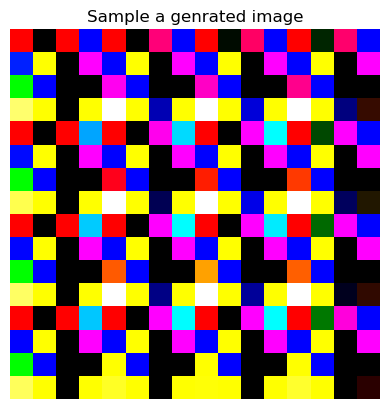

In [11]:
G_eval = G.to(device=torch.device('cpu'))
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G(noise)

# Denormalizing the image
image_generated = fake_images.detach().numpy().reshape((3,16,16))*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample a genrated image')
plt.show()

<strong> Plotting losses </strong>

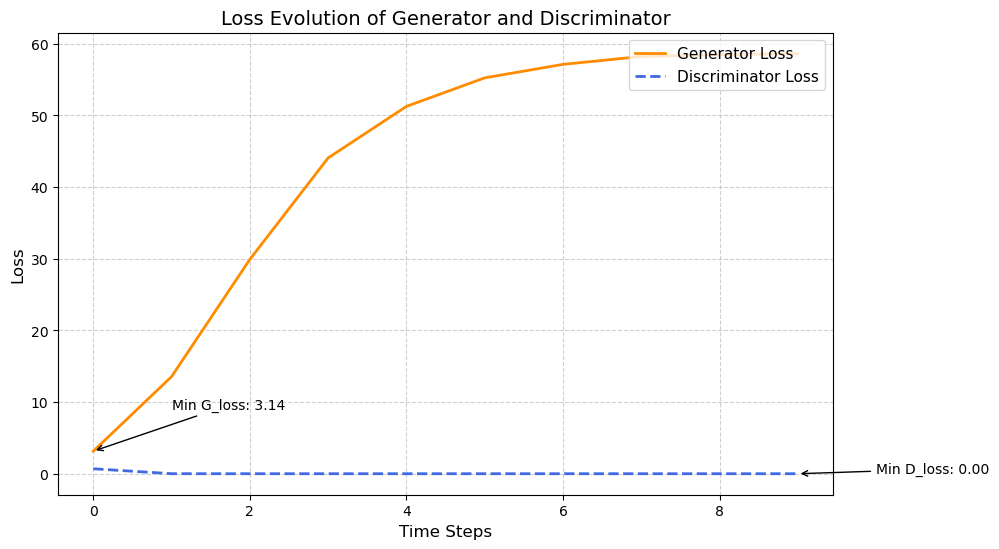

In [13]:
# Assuming G_loss and D_loss are defined
n = len(G_loss)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID (Fréchet Inception Distance) values </strong>

Text(0.5, 1.0, 'FID Evolution through training')

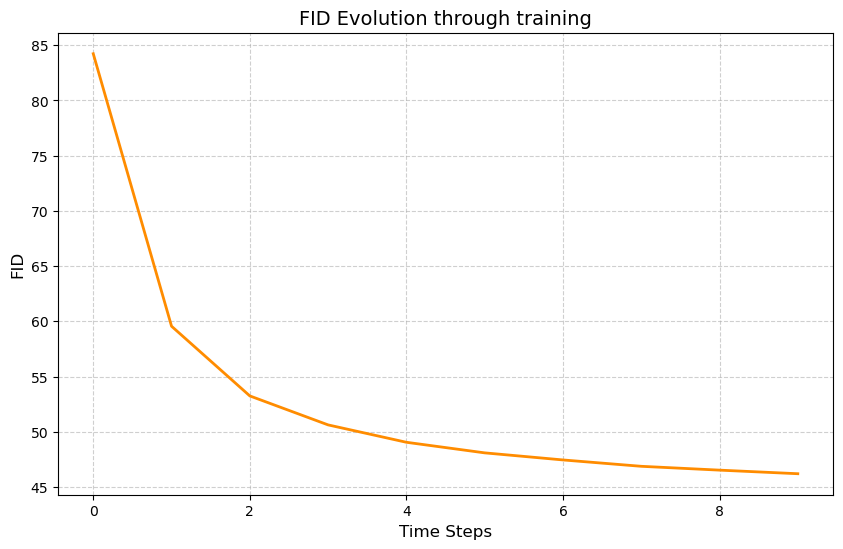

In [14]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)